## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
from keras.datasets import cifar10
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.np_utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [7]:
from keras.layers import BatchNormalization, Activation
from keras.layers import Dropout
from keras.regularizers import l1, l2, l1_l2
# 建立神經網路
# 使用batch-normalization, 不使用Dropout會Overfitting, 那加入regularization呢?
def build_mlp(input_shape, regularization, ratio, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1_l2(ratio))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1_l2(ratio))(x)
            x = BatchNormalization()(x)
                
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [12]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
DROPOUT = [True, False]

In [13]:
import tensorflow as tf
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
model = build_mlp(input_shape=x_train.shape[1:], regularization='l1_l2', 
                  ratio=0.0001,)
model.summary()
optimizer = tf.keras.optimizers.Adam(lr=LEARNING_RATE,
                                     beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True)

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["accuracy"]
valid_acc = model.history.history["val_accuracy"]        


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 3072)]            0         
                                                                 
 hidden_layer1 (Dense)       (None, 512)               1573376   
                                                                 
 batch_normalization_3 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 hidden_layer2 (Dense)       (None, 256)               131328    
                                                                 
 batch_normalization_4 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 hidden_layer3 (Dense)       (None, 128)               3289

C:\Users\TB890239\Anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/50
196/196 [==============================] - 9s 41ms/step - loss: 7.9410 - accuracy: 0.3854 - val_loss: 4.0078 - val_accuracy: 0.1715
Epoch 2/50
196/196 [==============================] - 7s 38ms/step - loss: 2.8097 - accuracy: 0.4034 - val_loss: 3.1288 - val_accuracy: 0.2131
Epoch 3/50
196/196 [==============================] - 8s 40ms/step - loss: 2.3989 - accuracy: 0.4103 - val_loss: 2.8753 - val_accuracy: 0.1907
Epoch 4/50
196/196 [==============================] - 8s 39ms/step - loss: 2.2323 - accuracy: 0.4209 - val_loss: 3.9181 - val_accuracy: 0.1460
Epoch 5/50
196/196 [==============================] - 8s 40ms/step - loss: 2.1897 - accuracy: 0.4273 - val_loss: 2.6852 - val_accuracy: 0.2268
Epoch 6/50
196/196 [==============================] - 8s 39ms/step - loss: 2.1480 - accuracy: 0.4329 - val_loss: 3.5561 - val_accuracy: 0.1698
Epoch 7/50
196/196 [==============================] - 8s 42ms/step - loss: 2.1221 - accuracy: 0.4383 - val_loss: 3.3248 - val_accuracy: 0.1813

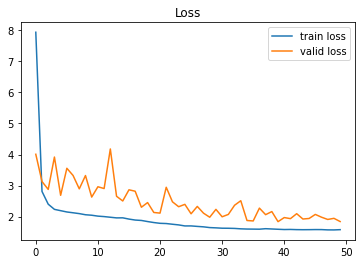

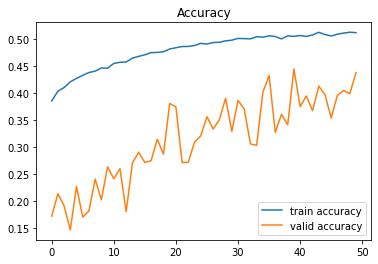

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

In [ ]:
# 有使用Dropout真的比較不會Overfitting，只用Batch Normalization還是產生Overfitting
# 明天試著加入Regularizers看看
# 結合Batch Normalization就沒有Overfitting了，看來不用執著單一方式孰優孰劣，混著一起用會更好。